# Machine Learning in Chess to Study Patterns in Chess Games


## Import Libraries


In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


## Load the Data


In [2]:
DATA_PATH = "/Users/isaac/Dropbox/Documents/University/Year 4/Project (ECM3401)/ChessDBs/lichess_db_standard_rated_2022"
# Check whether the DataFrame has been loaded correctly.
df = dd.read_parquet(DATA_PATH, engine="pyarrow")
print(f"Loaded {len(df)} Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.\n")
display(df)
display(df.head())


Loaded 63927025 Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.



,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
npartitions=153,,,,,,,,,,,,
,datetime64[ns],category[unknown],string,category[unknown],category[unknown],string,string,string,string,int16,int16,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
0,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Normal,D02,Queen's Pawn Game: Chigorin Variation,Kike73,Aox066,1255,1252,https://lichess.org/BPNsj2LF
1,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Normal,C40,King's Pawn Game: Busch-Gass Gambit,schachueli,HiddenEyes,1346,1308,https://lichess.org/ooDjyGrm
2,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,C02,"French Defense: Advance Variation, Nimzowitsch...",Renf7,Euphorbe92,859,964,https://lichess.org/T4TIdZZM
3,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,B10,Caro-Kann Defense: Accelerated Panov Attack,Ralza63,FN2718,1769,1702,https://lichess.org/Oz5OFohi
4,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Time forfeit,A41,Queen's Pawn Game,arkchess1963,sirkkeli,2146,2196,https://lichess.org/iehbAAzy


## Get Distribution of Player Ratings


In [20]:
# Merge the counts into one, as the player's side isn't important.
white_rating_count = df["WhiteElo"].value_counts().compute()
black_rating_count = df["BlackElo"].value_counts().compute()
rating_counts = (
    pd.concat([white_rating_count, black_rating_count], axis=1).fillna(0).astype(int)
)
rating_counts = rating_counts.sum(axis=1)
# Find the minimum and maximum player rating.
max_rating = rating_counts.index.max()
min_rating = rating_counts.index.min()
print(f"Maximum player rating: {max_rating}")
print(f"Minimum player rating: {min_rating}")

# Define the bin edges for player ratings from 600 (minimum in Lichess) to the
# maximum in intervals of 200.
bin_size = 200
rating_bins = np.array([i for i in range(600, max_rating + bin_size, bin_size)])
rating_counts.index = pd.cut(rating_counts.index, bins=rating_bins)
merged_rating_counts = rating_counts.groupby(level=0).sum()
display(merged_rating_counts)


Maximum player rating: 3485
Minimum player rating: 600


(600, 800]       1036347
(800, 1000]      4869159
(1000, 1200]    11242416
(1200, 1400]    17564485
(1400, 1600]    23150584
(1600, 1800]    25317906
(1800, 2000]    22498480
(2000, 2200]    14115285
(2200, 2400]     5816418
(2400, 2600]     1709222
(2600, 2800]      420496
(2800, 3000]       73395
(3000, 3200]        7295
(3200, 3400]         459
(3400, 3600]           1
dtype: int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_11346/4275098620.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(indexes, rotation=60)


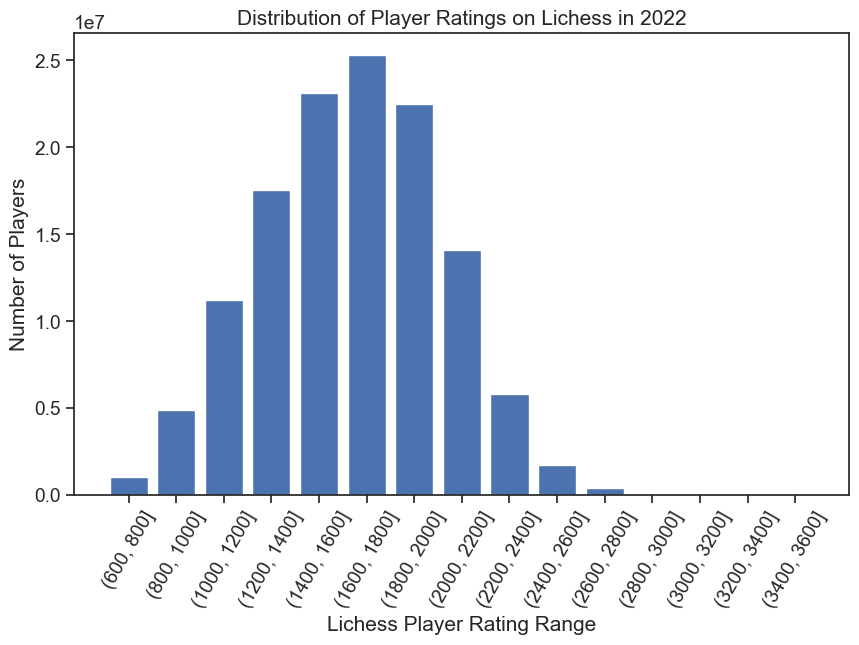

In [18]:
# Plot a graph to show the distribution of player ratings.
sns.set("talk")
sns.set(font_scale=1.25)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_rating_counts.index.astype(str)
values = merged_rating_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Player Ratings on Lichess in 2022")
ax.set_xlabel("Lichess Player Rating Range")
ax.set_ylabel("Number of Players")
ax.set_xticklabels(indexes, rotation=60)
plt.show()


## Get Most Popular Openings by Category


### All Rated Players

In [19]:
# Find the most common ECO categories.
eco_categories = df["ECO"].str[0].value_counts().compute()
print("All Players:")
display(eco_categories)


All Players:


C    19719467
B    18273490
A    16472856
D     8441510
E      984018
?       35684
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_34301/4245945799.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


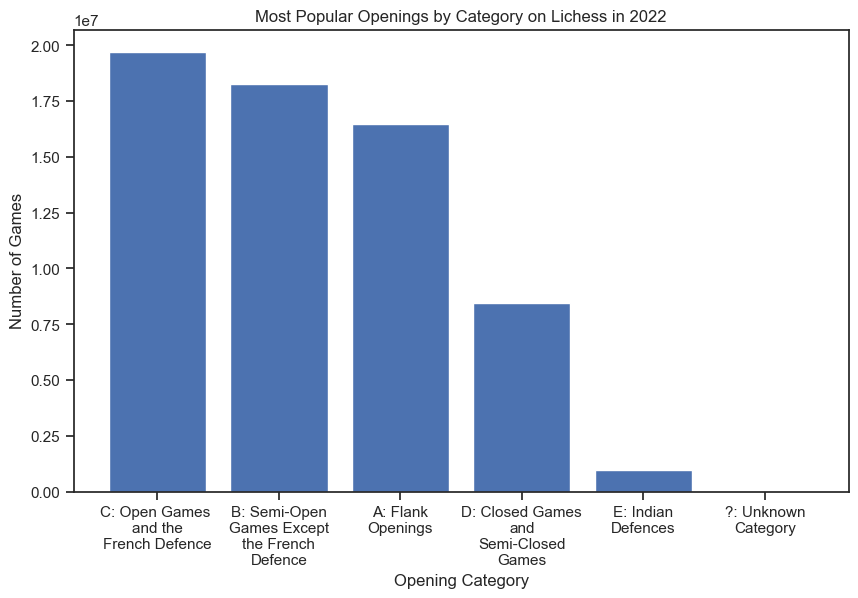

In [6]:
# Map each opening category to its type.
opening_category_map = {
    "A": "Flank\nOpenings",
    "B": "Semi-Open\nGames Except\nthe French\nDefence",
    "C": "Open Games \nand the\nFrench Defence",
    "D": "Closed Games\nand\nSemi-Closed\nGames",
    "E": "Indian\nDefences",
    "?": "Unknown\nCategory",
}

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = eco_categories.index
values = eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### High Rated Players (Rating 2000+)


Players with Rating 2000 and Above:


A    3660681
B    3608483
C    2000559
D    1443772
E     398581
?       6011
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_11346/201243510.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


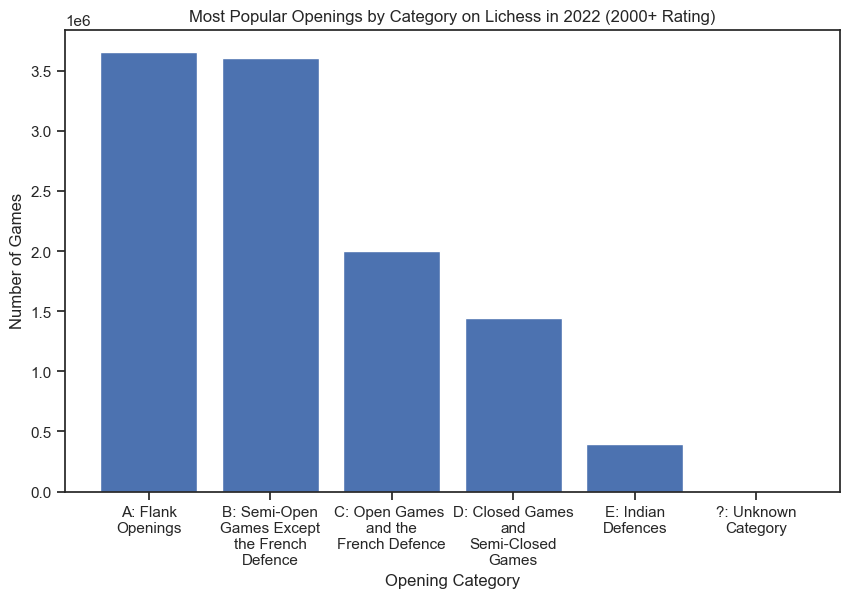

In [27]:
# Find the most common ECO categories for players rated 2000 and above.
high_rated_eco_categories = (
    df[df["WhiteElo"] >= 2000]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 2000 and Above:")
display(high_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_eco_categories.index
values = high_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Mid Rated Players (Rating 1201-1999)


Players with Rating 1201-1999:


C    14097806
B    12743233
A    10907977
D     5893625
E      556785
?       21626
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_11346/1021610847.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


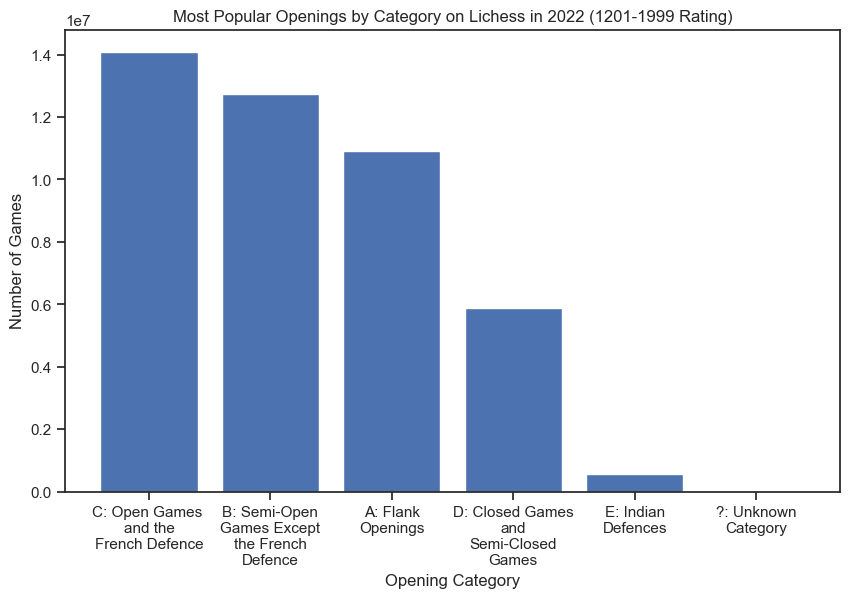

In [26]:
# Find the most common ECO categories for players rated 1401-1999.
mid_rated_eco_categories = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["ECO"]
    .str[0]
    .value_counts()
    .compute()
)
print("Players with Rating 1201-1999:")
display(mid_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_eco_categories.index
values = mid_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Low Rated Players (Rating 1200 and Below)


Players with Rating 1200 and Below:


C    3621102
B    1921774
A    1904198
D    1104113
E      28652
?       8047
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_11346/385155938.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


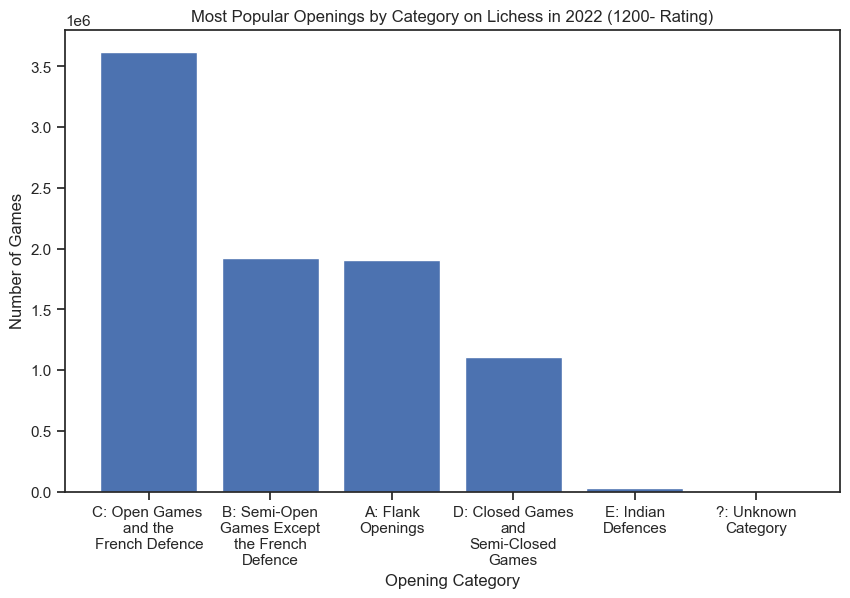

In [25]:
# Find the most common ECO categories for players rated 1400 and below.
low_rated_eco_categories = (
    df[df["WhiteElo"] <= 1200]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 1200 and Below:")
display(low_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_eco_categories.index
values = low_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 1200 and Below)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()

## Get Most Popular Openings


### All Rated Players


In [12]:
# Group variations of the same opening together by splitting on the colon.
opening_groups = df["Opening"].str.split(":").str[0].value_counts().compute()
display(opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
top_15_openings = opening_groups[:15]
top_15_openings_proportion = top_15_openings.sum() / opening_groups.sum()
print(
    f"The top 15 openings account for {top_15_openings_proportion:.2%} of all "
    "games on Lichess in 2022."
)


Sicilian Defense        6799525
Queen's Pawn Game       5274310
French Defense          3679831
Scandinavian Defense    3376155
Caro-Kann Defense       2918453
                         ...   
Venezolana Opening           72
Formation                    47
Dresden Opening              21
Veresov Opening              19
Amar Gambit                  18
Name: Opening, Length: 162, dtype: int64

The top 15 openings account for 61.79% of all games on Lichess in 2022.


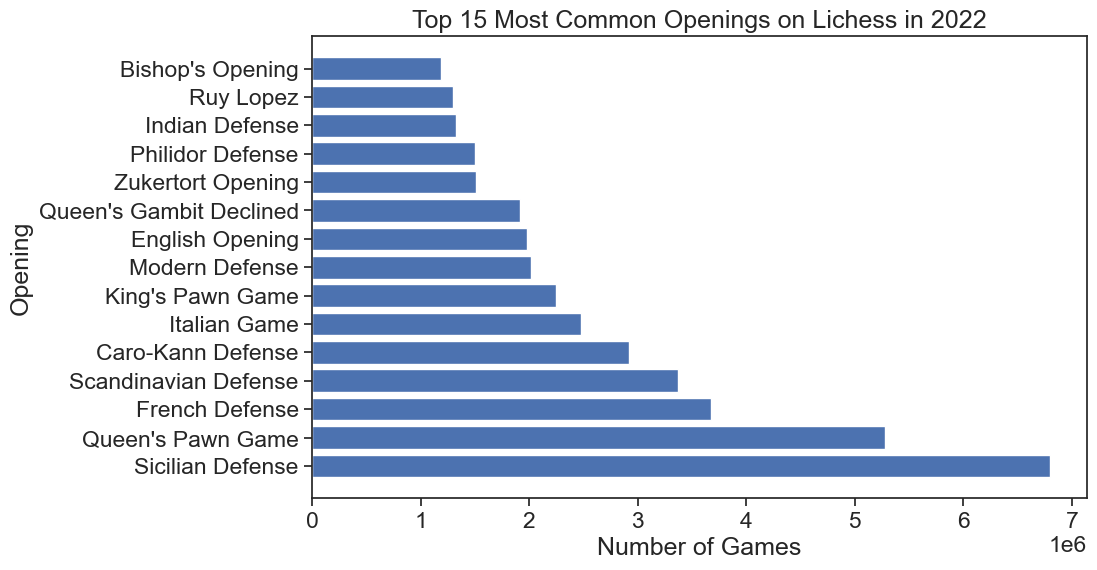

In [8]:
# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = opening_groups.index[:15]
values = opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### High Rated Players (Rating 2000+)


Sicilian Defense      1601681
Queen's Pawn Game      733921
French Defense         711170
Caro-Kann Defense      630566
English Opening        543504
                       ...   
Venezolana Opening         14
Amar Gambit                13
Veresov Opening            12
Amsterdam Attack            8
Tayler Opening              7
Name: Opening, Length: 161, dtype: int64

The top 15 openings for players rated 2000+ account for 11.45% of all games on Lichess in 2022.


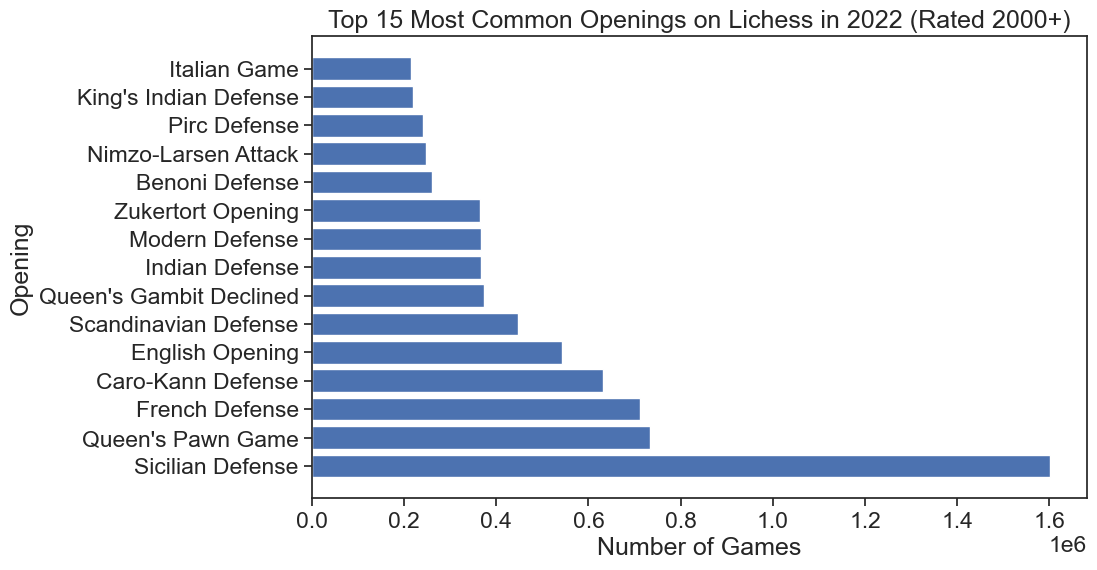

In [34]:
# Group variations of the same opening together by splitting on the colon.
high_rated_opening_groups = (
    df[df["WhiteElo"] >= 2000]["Opening"].str.split(":").str[0].value_counts().compute()
)
display(high_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
high_rated_top_15_openings = high_rated_opening_groups[:15]
high_rated_top_15_openings_proportion = (
    high_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 2000+ account for "
    f"{high_rated_top_15_openings_proportion:.2%} of all games on Lichess in "
    "2022."
)

# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_opening_groups.index[:15]
values = high_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Mid Rated Players (Rating 1201-1999)


Sicilian Defense                     4733754
Queen's Pawn Game                    3662720
French Defense                       2578350
Scandinavian Defense                 2415130
Caro-Kann Defense                    2029454
                                      ...   
Blumenfeld Countergambit Accepted         32
Formation                                 23
Dresden Opening                            8
Veresov Opening                            5
Amar Gambit                                4
Name: Opening, Length: 162, dtype: int64

The top 15 openings for players rated 1201-1999 account for 43.20% of all games on Lichess in 2022.


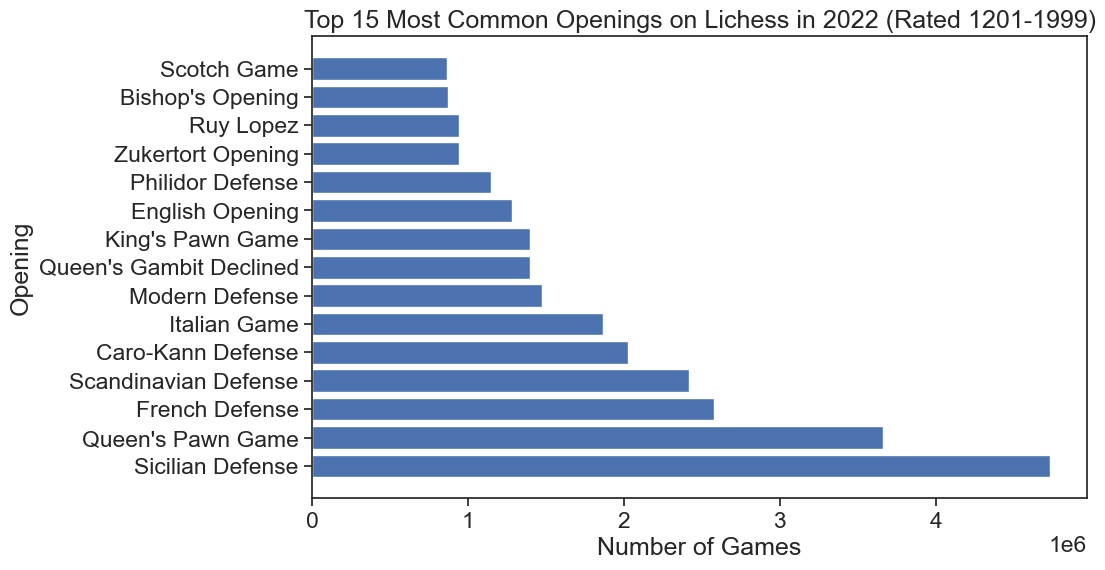

In [35]:
# Group variations of the same opening together by splitting on the colon.
mid_rated_opening_groups = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["Opening"]
    .str.split(":")
    .str[0]
    .value_counts()
    .compute()
)
display(mid_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
mid_rated_top_15_openings = mid_rated_opening_groups[:15]
mid_rated_top_15_openings_proportion = (
    mid_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 1201-1999 account for "
    f"{mid_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_opening_groups.index[:15]
values = mid_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Low Rated Players (Rating 1200 and Below)


Queen's Pawn Game                                                   877669
King's Pawn Game                                                    777348
Scandinavian Defense                                                513713
Sicilian Defense                                                    464090
Italian Game                                                        392874
                                                                     ...  
Marienbad System                                                         3
Veresov Opening                                                          2
Queen's Pawn Game, Zukertort Variation                                   2
Amar Gambit                                                              1
King's Indian Defense, Fianchetto Variation, Classical Variation         1
Name: Opening, Length: 161, dtype: int64

The top 15 openings for players rated 1200 and below account for 8.50% of all games on Lichess in 2022.


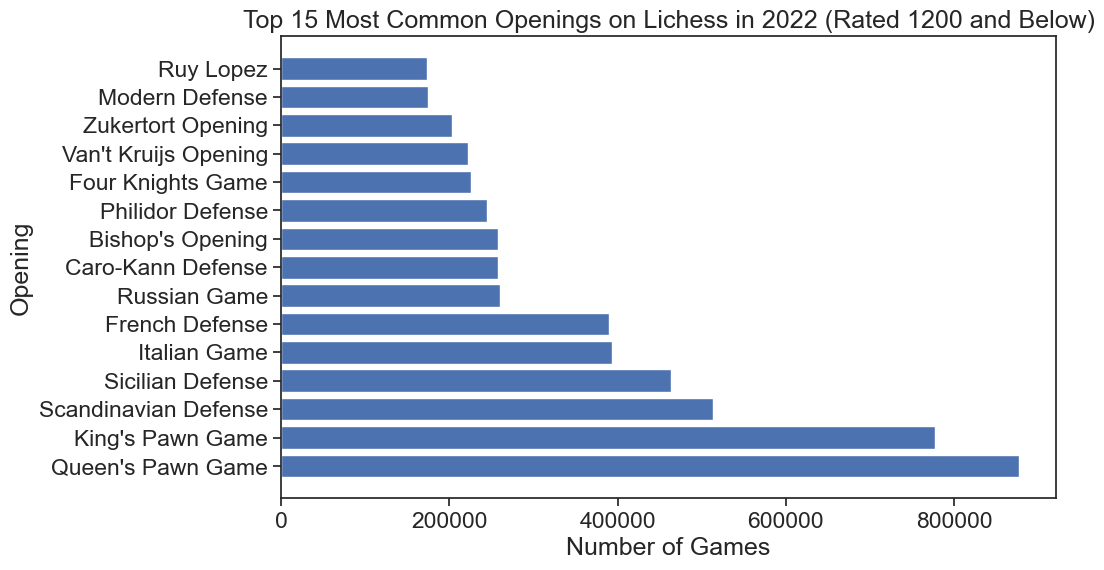

In [37]:
# Group variations of the same opening together by splitting on the colon.
low_rated_opening_groups = (
    df[df["WhiteElo"] <= 1200]["Opening"].str.split(":").str[0].value_counts().compute()
)
display(low_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
low_rated_top_15_openings = low_rated_opening_groups[:15]
low_rated_top_15_openings_proportion = (
    low_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 1200 and below account for "
    f"{low_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_opening_groups.index[:15]
values = low_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1200 and Below)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()
